In [1]:
from pathlib import Path
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from loguru import logger as log
log.remove()
log.add(sys.stdout, level="ERROR")


from ufish.api import UFish
from cellpose import models

from utils import (
    get_signal_masks, assign_spots, segment_cells, extract_cells,
    plot_figs, plot_all_rois
)
from skimage.measure import regionprops, label

In [2]:
# Cancer pathology samples
data_dir = "./data/"
img_paths = {
    path.stem: path for path in Path(data_dir).glob("*.TIF")
}

print(img_paths)

images = {
    name: np.array(PIL.Image.open(path))
    for name, path in img_paths.items()
}

{'Dual fusion': WindowsPath('data/Dual fusion.TIF'), 'separation probe': WindowsPath('data/separation probe.TIF'), 'Trisomy 8': WindowsPath('data/Trisomy 8.TIF')}


In [3]:
# initialize cellpose model
cp = models.Cellpose(gpu=False, model_type="nuclei")

# initialize ufish model
uf = UFish(device="cpu")
uf.load_weights("./v1.0.1-DNAFISH_model.onnx")

In [12]:
def filter_cell_by_prop(
        prop,
        img_size,
        area_threshold=1000,
        axis_ratio_threshold=0.8,
        border_threshold=10
        ):
    close_to_edge = False
    if prop.coords[:, 0].min() <= border_threshold or \
            prop.coords[:, 0].max() > img_size[0] - border_threshold or \
            prop.coords[:, 1].min() <= border_threshold or \
            prop.coords[:, 1].max() > img_size[1] - border_threshold:
        close_to_edge = True
    if close_to_edge:
        return False
    if prop.area < area_threshold:
        return False
    axis_ratio = prop.minor_axis_length / prop.major_axis_length
    if axis_ratio < axis_ratio_threshold:
        return False
    return True

def filter_cell_by_signals(signals, num_thresh=5):
    for _, signal in signals.items():
        if signal.shape[0] == 0:
            return False
        if signal.shape[0] > num_thresh:
            return False
    return True

In [13]:
from skimage.morphology import dilation, disk

# Define pipeline
def pipeline(img, signal_channels=[0, 1]):
    print("---------- Begin pipeline ----------")
    print(f"Image shape: {img.shape}")
    print("Step 1: segment cells")
    mask = segment_cells(cp, img)
    print(f"Number of cells: {mask.max()}")
    mask = dilation(mask, disk(3))

    print("Step 2: extract ROIs")
    cell_rois, cell_masks, cell_props = extract_cells(
        img, mask, target_size=128)
    
    print("Step 3: call signals and assign spots for each cell")
    table = []
    cell_signals = []
    new_cell_rois = []
    new_cell_masks = []
    new_cell_props = []
    for c, cell_roi in enumerate(cell_rois):
        cell_prop = cell_props[c]
        if not filter_cell_by_prop(cell_prop, mask.shape):
            continue
        signal_mask_merge, signal_masks_sub = get_signal_masks(
            uf, cell_roi, signal_channels, quantile=10,
            hard_threshold=100
            )
        signals = {}
        for ch in signal_channels:
            signals[f"ch{ch+1}"] = []
        name = "+".join([f"ch{ch+1}" for ch in signal_channels])
        signals[name] = []
        for i, ch in enumerate(signal_channels):
            single_ch = regionprops(label(signal_masks_sub[i]))
            spots = np.array([cc.centroid for cc in single_ch])
            signals[f"ch{ch+1}"] = spots
        merged = regionprops(label(signal_mask_merge))
        spots = np.array([cc.centroid for cc in merged])
        name = "+".join([f"ch{ch+1}" for ch in signal_channels])
        signals[name] = spots

        if not filter_cell_by_signals(signals):
            continue

        assigns = {}
        for name, spots in signals.items():
            try:
                assigns[name] = assign_spots(spots, cell_masks[c], 30)
            except Exception:
                assigns[name] = []

        df = {
            key: sum(value) for key, value in assigns.items()
            if isinstance(value, np.ndarray)
        }
        df["cell_id"] = f'{c+1}'
        last_key = list(df.keys())[-1]
        last_value = df.pop(last_key)
        df = {last_key: last_value, **df}
        table.append(df)
        cell_signals.append(signals)
        new_cell_rois.append(cell_roi)
        new_cell_masks.append(cell_masks[c])
        new_cell_props.append(cell_props[c])
    return pd.DataFrame(table).fillna(0), new_cell_rois, new_cell_masks, cell_signals, new_cell_props


In [14]:
from shutil import rmtree
import os
main_dir = "results"
os.makedirs(main_dir, exist_ok=True)
for name, img in images.items():
    print(name)
    res_dir = f"./{main_dir}/{name}"
    if os.path.exists(res_dir):
        rmtree(f"./{res_dir}")
    os.mkdir(f"./{res_dir}")

    if name.startswith("Trisomy"):
        signal_channels=[0]
    else:
        signal_channels=[0, 1]
    img = img[:1000, :1000, :]
    table, rois, masks, signals, props = pipeline(img, signal_channels)
    plot_figs(rois, masks, signals, res_dir)

    fig = plot_all_rois(rois, masks, signals, colors={"ch1": "hotpink", "ch2": "lime", "ch1+ch2": "yellow"})
    fig.savefig(f"{res_dir}/{name}_all_cells.pdf")
    plt.close(fig)

    table.to_csv(f"{res_dir}/{name}_results.csv", index=False)


Dual fusion
---------- Begin pipeline ----------
Image shape: (1000, 1000, 3)
Step 1: segment cells
Number of cells: 63
Step 2: extract ROIs
Step 3: call signals and assign spots for each cell
separation probe
---------- Begin pipeline ----------
Image shape: (1000, 1000, 3)
Step 1: segment cells
Number of cells: 46
Step 2: extract ROIs
Step 3: call signals and assign spots for each cell
Trisomy 8
---------- Begin pipeline ----------
Image shape: (1000, 1000, 3)
Step 1: segment cells
Number of cells: 51
Step 2: extract ROIs
Step 3: call signals and assign spots for each cell


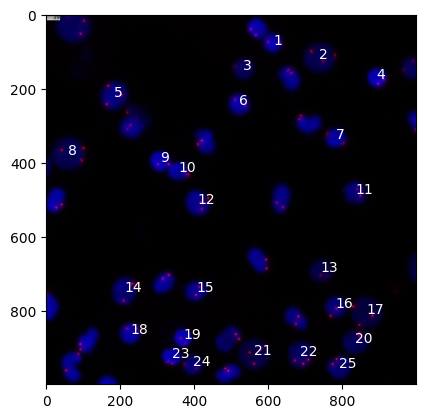

In [7]:
plt.imshow(img)
for i, prop in enumerate(props):
    plt.text(
        prop.centroid[1],
        prop.centroid[0],
        f"{i+1}",
        color="white"
    )

In [8]:
mask = segment_cells(cp, img)

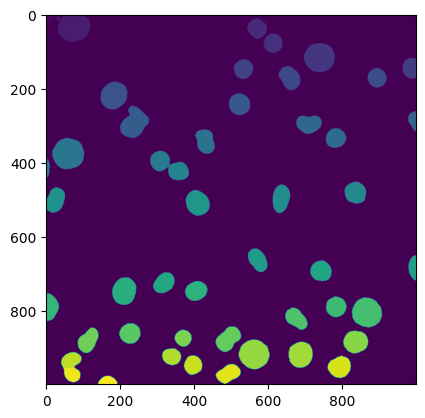

In [9]:
plt.imshow(mask)